## 1. Setup and Load Libraries

In [3]:
!pip install imblearn

In [8]:
import numpy as np
import pandas as pd


from sklearn.preprocessing import KBinsDiscretizer
import shap
from sklearn.ensemble import RandomForestClassifier

#------------------------------------Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import joblib 
from sklearn.model_selection import StratifiedGroupKFold


spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "false")
pd.set_option('display.max_columns', 500)

#--------------------Model

import importlib
import modeling_utils
importlib.reload(modeling_utils) 
from eda_utils import calculate_psi, plot_distribution_plotly, calculate_woe_iv

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from modeling_utils import optimize_hyperparameters
from sklearn.metrics import precision_recall_curve, roc_auc_score, classification_report, f1_score, confusion_matrix, roc_curve, auc, precision_score, recall_score,  brier_score_loss
import optuna
from modeling_utils import plot_model_evaluation_summary
from sklearn.calibration import calibration_curve, CalibrationDisplay, IsotonicRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split

from modeling_utils import generate_classification_report
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler,  InstanceHardnessThreshold
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import ClusterCentroids, NearMiss
from sklearn.model_selection import StratifiedGroupKFold

# Global Functions and Variables

In [5]:
features = ['home_ownership', 'addr_state', 'dti', 'fico_range_high', 'all_util',
       'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'mths_since_recent_inq', 'num_actv_rev_tl',
       'emp_length_numeric', 'emp_title_final_grouped', 'title_grouped',
       'region_median_income', 'loan_to_income_ratio', 'open_acc_ratio']

## 2. Load Data



In [6]:
df_model = pd.read_csv('df_total_woe.csv')


df_model.head(10)

,id,d_vintage,funded_amnt,int_rate,sub_grade,home_ownership,annual_inc,verification_status,addr_state,dti,fico_range_high,all_util,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_actv_rev_tl,emp_length_numeric,term_numeric,emp_title_final_grouped,title_grouped,region_median_income,loan_to_income_ratio,revolving_balance_to_income_ratio,credit_utilization_manual,open_acc_ratio,set,target
0,68407277,2015-12-01,0.258841,-0.104389,-0.287373,0.160306,-0.086534,0.365801,-0.067006,0.403308,-0.217115,0.106942,-0.405376,0.024740,0.156173,-0.155903,-0.077618,-0.148191,-0.172215,-0.034501,-0.169441,-0.089716,0.084253,0.057010,0.310279,-0.020484,-0.007931,0.099562,0.457006,0.063355,0.023397,-0.007500,train,0.0
1,68355089,2015-12-01,-0.152670,0.229718,0.088483,0.160306,-0.030447,0.365801,-0.101768,0.107425,0.280817,0.106942,-0.405376,0.024740,-0.056093,0.630465,0.061496,-0.179923,-0.205649,0.238651,-0.252891,-0.260049,0.020176,0.057010,0.310279,0.172054,-0.081017,-0.075997,-0.478301,-0.066297,0.283653,-0.079388,train,0.0
2,68341763,2015-12-01,-0.152670,0.440679,0.355937,0.160306,-0.030447,0.365801,0.120678,0.282040,0.021937,-0.231529,-0.044784,-0.181297,0.378525,-0.139264,0.037777,0.025413,0.188066,0.238651,0.391569,0.047732,0.161126,0.057010,-0.721577,-0.313243,-0.081017,0.099562,-0.326559,0.111091,-0.045164,0.112083,train,0.0
3,68476807,2015-12-01,-0.052293,-1.109875,-1.167190,0.160306,0.262201,-0.078360,-0.067006,-0.164547,0.021937,-0.398292,-0.405376,-0.578527,0.378525,-0.075754,0.061496,-0.111674,-0.098426,0.350769,-0.169441,-0.260049,-0.044349,0.010116,-0.721577,-0.020484,-0.007931,-0.035045,0.387752,0.023428,-0.098688,0.112083,train,0.0
4,68426831,2015-12-01,-0.052293,-0.104389,-0.155127,-0.168686,-0.212208,-0.078360,0.094121,0.282040,-0.044342,-0.398292,-0.044784,0.456646,-0.176827,-0.194252,-0.392487,0.400004,0.495469,-0.189779,0.152740,0.000000,0.161126,0.010116,0.310279,-0.020484,-0.007931,0.054853,-0.478301,-0.032938,-0.127045,-0.226646,train,0.0
5,68476668,2015-12-01,-0.152670,0.736853,0.669339,0.160306,0.366531,0.365801,-0.014735,0.193799,-0.182636,-0.398292,-0.044784,-0.181297,0.378525,-0.347748,0.191351,0.001416,0.131069,0.238651,-0.076567,0.047732,-0.044349,0.057010,0.310279,0.012941,-0.007931,0.054853,0.387752,-0.141886,-0.339684,0.037363,train,0.0
6,67275481,2015-12-01,-0.152670,0.736853,0.769896,0.160306,0.072425,0.365801,0.255807,0.059621,0.123391,-0.231529,-0.044784,0.024740,0.109081,0.184215,-0.392487,0.400004,0.188066,0.169388,0.152740,0.047732,0.237851,0.057010,0.310279,-0.313243,-0.007931,-0.127956,-0.024098,0.043867,0.290291,-0.007500,train,0.0
7,68466926,2015-12-01,0.107043,1.752382,1.801500,-0.168686,0.072425,0.365801,-0.067006,0.193799,-0.084299,0.106942,-0.044784,-0.264431,-0.176827,0.040141,-0.077618,-0.283219,-0.285198,-0.034501,-0.169441,-0.260049,-0.215452,0.010116,0.310279,0.012941,-0.007931,-0.035045,0.360100,0.111091,0.087131,-0.079388,train,0.0
8,68616873,2015-12-01,0.206653,0.229718,0.239685,0.160306,-0.155503,0.365801,0.120678,-0.534175,0.123391,0.106942,-0.044784,-0.079886,0.378525,0.099580,0.137563,0.025413,0.131069,-0.034501,0.184122,0.047732,0.161126,0.057010,0.310279,-0.020484,-0.007931,-0.035045,0.168854,0.059959,0.187460,0.037363,train,0.0
9,68338832,2015-12-01,0.341164,0.055929,-0.039680,0.160306,-0.030447,0.365801,-0.059460,-0.534175,0.123391,-0.231529,-0.044784,0.024740,0.156173,0.040141,0.137563,0.119783,-0.205649,0.238651,0.069577,0.231346,-0.374405,0.010116,0.310279,-0.313243,-0.081017,-0.035045,0.586774,-0.141886,-0.098688,-0.181678,train,0.0


# Data Splitting

In [7]:
X_train_i = df_model[df_model['set']=='train'].drop(['target', 'set'], axis=1).set_index(['id',	'd_vintage'])
y_train_i = df_model[df_model['set']=='train'].set_index(['id',	'd_vintage'])[['target']]


X_test = df_model[df_model['set']=='test'].drop(['target', 'set'], axis=1).set_index(['id',	'd_vintage'])
y_test = df_model[df_model['set']=='test'].set_index(['id',	'd_vintage'])[['target']]

print('Training data dimension', X_train_i.shape, y_train_i.shape)
print('Test data dimension', X_test.shape, y_test.shape)

###-----------------------------------------------------------------------------------------------------------------


#-----------------------------------------------------------------------
X_train_i= X_train_i.drop(['sub_grade','credit_utilization_manual', 'revolving_balance_to_income_ratio', 'mo_sin_rcnt_rev_tl_op','int_rate', 'funded_amnt', 'term_numeric', 'verification_status', 'annual_inc'] , axis=1)

X_test = X_test.drop(['sub_grade', 'credit_utilization_manual', 'revolving_balance_to_income_ratio', 'mo_sin_rcnt_rev_tl_op', 'int_rate', 'funded_amnt', 'term_numeric', 'verification_status', 'annual_inc'], axis=1)


X_train, X_calib, y_train, y_calib = train_test_split(
    X_train_i, y_train_i,
    test_size=0.3,      
    random_state=42,
    stratify=y_train_i )


Training data dimension (1004232, 30) (1004232, 1)
Test data dimension (343827, 30) (343827, 1)


## 3. Apply Random Undersampling


In [ ]:

print("Applying InstanceHardnessThreshold sampler...")

# --- 1. Initialize the Sampler ---
iht_sampler = InstanceHardnessThreshold(
    random_state=42,
    n_jobs=-1
)

# --- 2. Apply the Resampling ---
# This will train the internal model and then remove the "easy" samples.

# THE FIX IS HERE: We convert y_train_i to integer type before passing it.
print("Ensuring target variable is integer type...")
y_train_for_resampling = y_train_i.astype(int)

X_train_resampled, y_train_resampled = iht_sampler.fit_resample(X_train_i, y_train_for_resampling)

# --- 3. Show Results ---
print("\n--- Resampled Training Data (using Instance Hardness Threshold) ---")
print(f"Original training set size: {len(X_train_i)}")
print(f"Resampled training set size: {len(X_train_resampled)}")
print("Note: The dataset is not perfectly balanced, it's cleaned.")

Applying InstanceHardnessThreshold sampler...
Ensuring target variable is integer type...

--- Resampled Training Data (using Instance Hardness Threshold) ---
Original training set size: 1004232
Resampled training set size: 396214
Note: The dataset is not perfectly balanced, it's cleaned.


In [ ]:
sampling_ratios_to_test = [0.10, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0] 
n_splits = 10
cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)

results = {}

# --- 2. Prepare Data ---
train_df = X_train_i.reset_index().merge(y_train_i.reset_index(), on=['id', 'd_vintage'], how='inner')
# Asumo que 'dti' ya está binnificada o es una variable WoE como 'fico_range_high'
# Si 'dti' tiene muchos valores únicos, deberías binnificarla también.

print("Starting optimization of sampling ratio for AUC with triple stratification...")
for ratio in sampling_ratios_to_test:
    print(f"--- Testing Ratio: {ratio} ---")
    fold_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(train_df[features], train_df['target'], groups=train_df['d_vintage'])):
        
        train_fold_df = train_df.iloc[train_idx]
        X_val_fold = train_df.iloc[val_idx][features]
        y_val_fold = train_df.iloc[val_idx]['target']

        # a. Apply stratified undersampling
        resampled_dfs_fold = []
        stratification_groups = ['d_vintage', 'fico_range_high', 'dti'] # Usando las 3 variables
        for group_keys, group_df in train_fold_df.groupby(stratification_groups):
            minority_df = group_df[group_df['target'] == 1]
            majority_df = group_df[group_df['target'] == 0]
            
            if not minority_df.empty and not majority_df.empty:
                # **LÓGICA CORREGIDA Y SIMPLIFICADA**
                # El número de muestras mayoritarias es el de minoritarias dividido por el ratio
                n_samples = int(len(minority_df) / ratio)
                n_samples = min(n_samples, len(majority_df))

                majority_downsampled = majority_df.sample(n=n_samples, random_state=42)
                resampled_dfs_fold.append(pd.concat([majority_downsampled, minority_df]))
        
        if not resampled_dfs_fold:
            print(f"  Fold {fold+1}/{n_splits}, Skipped: No data after resampling.")
            continue

        train_df_resampled_fold = pd.concat(resampled_dfs_fold)
        X_train_resampled_fold = train_df_resampled_fold[features]
        y_train_resampled_fold = train_df_resampled_fold['target']

        # b. Train the model
        model = LogisticRegression(solver='liblinear', random_state=42)
        model.fit(X_train_resampled_fold, y_train_resampled_fold)

        # c. Evaluate on the validation part of the fold using AUC
        # <--- 2. Predecir probabilidades, no clases
        y_pred_proba_val = model.predict_proba(X_val_fold)[:, 1] 
        
        # <--- 3. Calcular AUC
        score = roc_auc_score(y_val_fold, y_pred_proba_val) 
        fold_scores.append(score)
        print(f"  Fold {fold+1}/{n_splits}, AUC: {score:.4f}") # <--- 4. Imprimir AUC

    # Calculate average score for the current ratio
    if fold_scores:
        mean_score = np.mean(fold_scores)
        results[ratio] = mean_score
        print(f"Average AUC for ratio {ratio}: {mean_score:.4f}\n") # <--- 5. Imprimir AUC promedio
    else:
        print(f"No scores recorded for ratio {ratio}.\n")

# --- 4. Select the Best Ratio ---
if results:
    best_ratio = max(results, key=results.get)
    print(f"Optimization complete.")
    print(f"Best sampling ratio: {best_ratio} with an average AUC of {results[best_ratio]:.4f}") # <--- 6. Imprimir resultado final
else:
    print("Optimization complete, but no valid results were found.")

Starting optimization of sampling ratio for AUC with triple stratification...
--- Testing Ratio: 0.15 ---
  Fold 1/10, AUC: 0.6883
  Fold 2/10, AUC: 0.6773
  Fold 3/10, AUC: 0.6806
  Fold 4/10, AUC: 0.6715
  Fold 5/10, AUC: 0.6779
  Fold 6/10, AUC: 0.6781
  Fold 7/10, AUC: 0.6850
  Fold 8/10, AUC: 0.6799
  Fold 9/10, AUC: 0.6752
  Fold 10/10, AUC: 0.6824
Average AUC for ratio 0.15: 0.6796

--- Testing Ratio: 0.2 ---
  Fold 1/10, AUC: 0.6852
  Fold 2/10, AUC: 0.6740
  Fold 3/10, AUC: 0.6779
  Fold 4/10, AUC: 0.6684
  Fold 5/10, AUC: 0.6750
  Fold 6/10, AUC: 0.6744
  Fold 7/10, AUC: 0.6816
  Fold 8/10, AUC: 0.6769
  Fold 9/10, AUC: 0.6723
  Fold 10/10, AUC: 0.6791
Average AUC for ratio 0.2: 0.6765

--- Testing Ratio: 0.25 ---
  Fold 1/10, AUC: 0.6796
  Fold 2/10, AUC: 0.6683
  Fold 3/10, AUC: 0.6728
  Fold 4/10, AUC: 0.6628
  Fold 5/10, AUC: 0.6699
  Fold 6/10, AUC: 0.6683
  Fold 7/10, AUC: 0.6757
  Fold 8/10, AUC: 0.6716
  Fold 9/10, AUC: 0.6672
  Fold 10/10, AUC: 0.6733
Average AUC for

In [9]:
best_ratio = 0.15


train_df = X_train.reset_index().merge(y_train.reset_index(), on=['id', 'd_vintage'], how='inner')

print(f"Applying final stratified undersampling with ratio: {best_ratio}")
print("Stratifying by 'd_vintage' and the pre-binned 'fico_range_high' (WoE) variable.")
print(f"Original training data shape: {train_df.shape}")
print(f"Original target distribution:\n{train_df['target'].value_counts(normalize=True)}\n")


# --- 2. Aplicar el Muestreo Estratificado ---
resampled_dfs = []
# **CORRECCIÓN**: Agrupamos directamente por la variable WoE.
stratification_groups = ['d_vintage', 'fico_range_high', 'dti'] 

for group_keys, group_df in train_df.groupby(stratification_groups):
    minority_df = group_df[group_df['target'] == 1]
    majority_df = group_df[group_df['target'] == 0]
    
    if not minority_df.empty and not majority_df.empty:
        # Calcular el número de muestras de la clase mayoritaria a conservar
        n_samples = int(len(minority_df) / best_ratio)
        n_samples = min(n_samples, len(majority_df))

        # Muestrear la clase mayoritaria
        majority_downsampled = majority_df.sample(n=n_samples, random_state=42)
        
        # Combinar y guardar
        resampled_dfs.append(pd.concat([majority_downsampled, minority_df]))

# --- 3. Crear el DataFrame Final Remuestreado ---
train_df_final_resampled = pd.concat(resampled_dfs).sample(frac=1, random_state=42) # Mezclar filas

# Separar en X y y finales
X_train_final = train_df_final_resampled[features]
y_train_final = train_df_final_resampled['target']

# --- 4. Mostrar Resultados ---
print("\n--- Final Resampled Training Data ---")
print(f"Final resampled data shape: {X_train_final.shape}")
print(f"Final target distribution:\n{y_train_final.value_counts(normalize=True)}")

Applying final stratified undersampling with ratio: 0.15
Stratifying by 'd_vintage' and the pre-binned 'fico_range_high' (WoE) variable.
Original training data shape: (702962, 24)
Original target distribution:
target
0.0    0.809004
1.0    0.190996
Name: proportion, dtype: float64


--- Final Resampled Training Data ---
Final resampled data shape: (635687, 21)
Final target distribution:
target
0.0    0.78945
1.0    0.21055
Name: proportion, dtype: float64


## 4. Train Logistic Regression Model

In [10]:

best_logistic_params = {
    'C':  0.6,
    'penalty': 'l1',
    'solver': 'liblinear',
    'random_state': 42
}


final_logistic_model = LogisticRegression(**best_logistic_params)
final_logistic_model.fit(X_train_final, y_train_final)


LogisticRegression(C=0.6, penalty='l1', random_state=42, solver='liblinear')

/var/folders/v4/7dg4p38j5c31bxdhb2vhmmb00000gp/T/ipykernel_56460/139822414.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




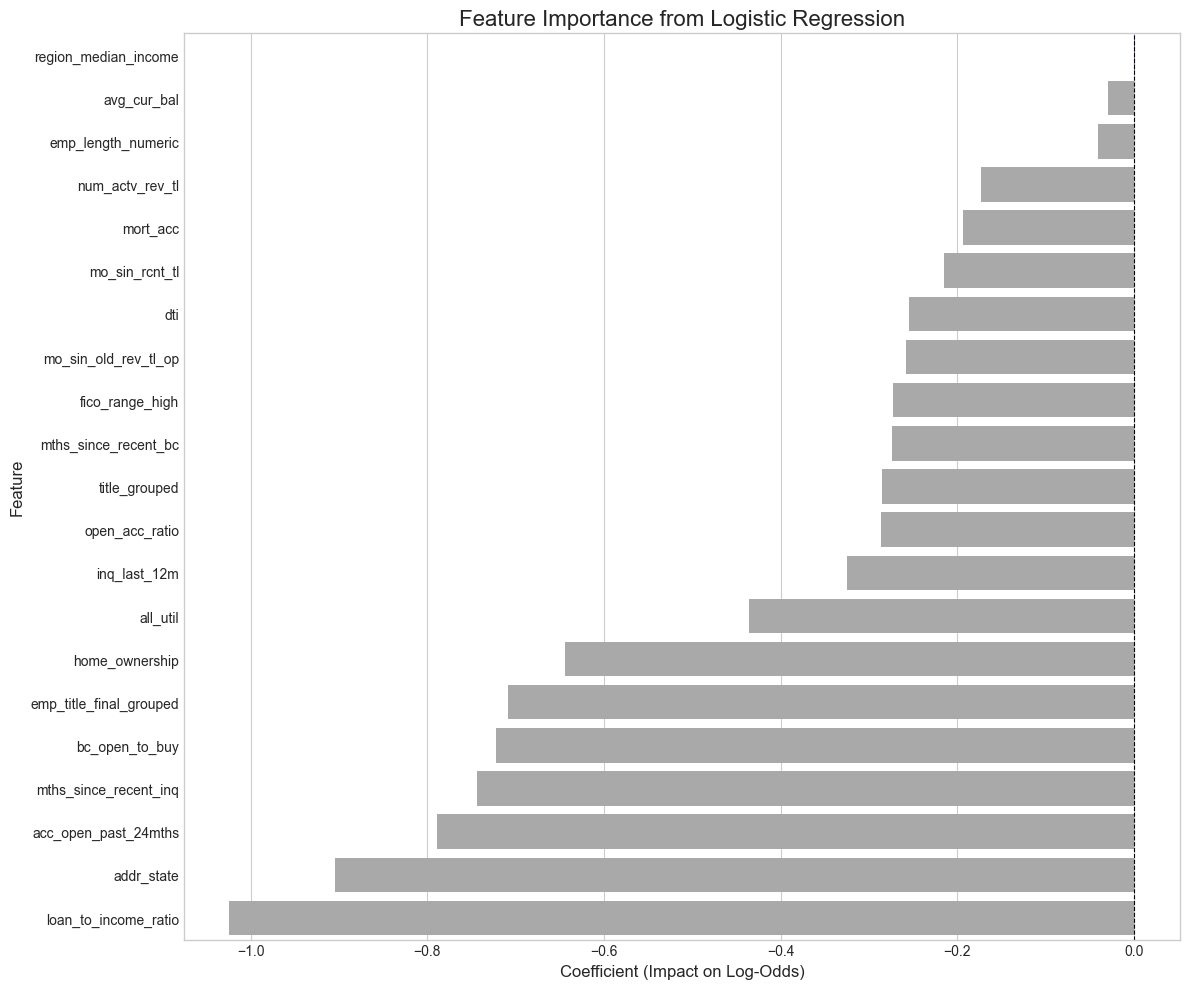

In [11]:

coefficients = final_logistic_model.coef_[0]
feature_names = X_train.columns


coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})


coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

plt.style.use('seaborn-v0_8-whitegrid') 
fig, ax = plt.subplots(figsize=(12, 10)) 


colors = ['#9b59b6' if c > 0 else "#a9a9a9" for c in coef_df['Coefficient']]


sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette=colors, ax=ax)


ax.axvline(0, color='black', linewidth=0.8, linestyle='--')


ax.set_title('Feature Importance from Logistic Regression', fontsize=16)
ax.set_xlabel('Coefficient (Impact on Log-Odds)', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)


plt.tight_layout()
plt.show()


## 5. Calibrate Model Probabilities

We calibrate the model on the original, untouched calibration set.

--- Getting probabilities on the calibration set ---
--- Training the isotonic calibrator ---
Calibrator trained.

--- Evaluating and visualizing on the Test set ---


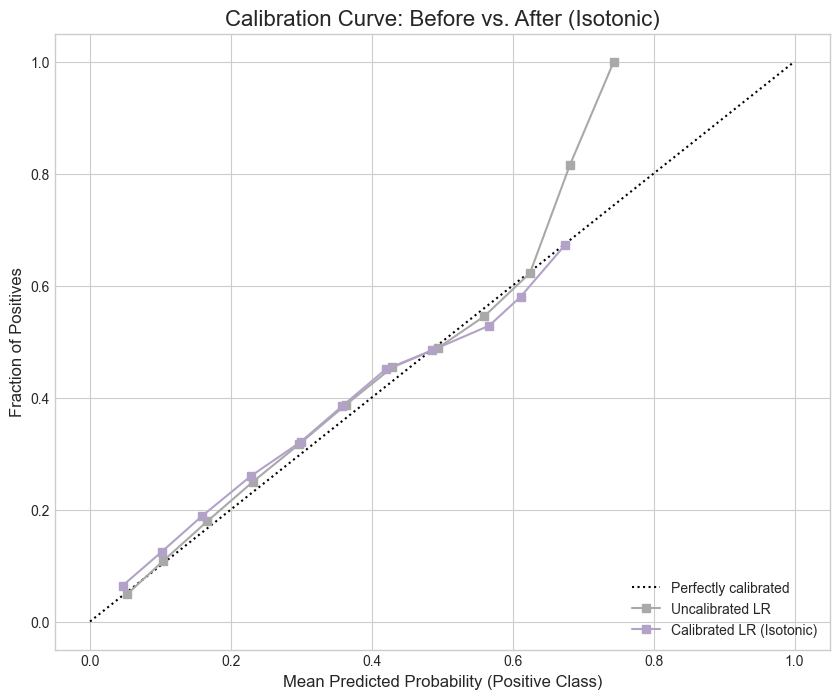


--- AUC Comparison on Test Set ---
AUC of uncalibrated model: 0.6755
AUC of calibrated model:    0.6754


In [12]:

colors = {
    "main_purple": "#b3a2c7",
    "medium_grey": "#a9a9a9"
}


print("--- Getting probabilities on the calibration set ---")
y_pred_calib_proba = final_logistic_model.predict_proba(X_calib)[:, 1]

print("--- Training the isotonic calibrator ---")

y_calib_flat = y_calib.values.ravel()
lr_isotonic_calibrator = IsotonicRegression(out_of_bounds='clip')
lr_isotonic_calibrator.fit(y_pred_calib_proba, y_calib_flat)
print("Calibrator trained.")

print("\n--- Evaluating and visualizing on the Test set ---")

y_pred_test_uncalibrated_proba = final_logistic_model.predict_proba(X_test)[:, 1]


y_pred_test_calibrated_proba = lr_isotonic_calibrator.transform(y_pred_test_uncalibrated_proba)


fig, ax = plt.subplots(figsize=(10, 8))


CalibrationDisplay.from_predictions(
    y_test,
    y_pred_test_uncalibrated_proba,
    n_bins=15,
    name='Uncalibrated LR',
    ax=ax,
    strategy='uniform',
    color=colors["medium_grey"]  
)

CalibrationDisplay.from_predictions(
    y_test,
    y_pred_test_calibrated_proba,
    n_bins=15,
    name='Calibrated LR (Isotonic)',
    ax=ax,
    strategy='uniform',
    color=colors["main_purple"]  
)


ax.set_title('Calibration Curve: Before vs. After (Isotonic)', fontsize=16)
ax.set_xlabel("Mean Predicted Probability (Positive Class)", fontsize=12)
ax.set_ylabel("Fraction of Positives", fontsize=12)
plt.show()


auc_test_uncalibrated = roc_auc_score(y_test, y_pred_test_uncalibrated_proba)
auc_test_calibrated = roc_auc_score(y_test, y_pred_test_calibrated_proba)

print(f"\n--- AUC Comparison on Test Set ---")
print(f"AUC of uncalibrated model: {auc_test_uncalibrated:.4f}")
print(f"AUC of calibrated model:    {auc_test_calibrated:.4f}")

## 6. Find Optimal Decision Threshold

The optimal threshold is found using the predictions on the calibration set to maximize the F1-score.

In [13]:

uncalibrated_proba = final_logistic_model.predict_proba(X_calib)[:, 1]

y_pred_proba = lr_isotonic_calibrator.predict(uncalibrated_proba)


precisions, recalls, thresholds = precision_recall_curve(y_calib, y_pred_proba)


results_df = pd.DataFrame({
    'Threshold': thresholds,
    'Precision': precisions[:-1],
    'Recall': recalls[:-1]
})

# Add F1-Score for a more balanced view
# Avoid division by zero if precision and recall are both 0
results_df['F1-Score'] = 2 * (results_df['Precision'] * results_df['Recall']) / \
                        (results_df['Precision'] + results_df['Recall']).replace(0, 1e-9)

print("--- Threshold Analysis Results ---")

display(results_df.sort_values(by='F1-Score', ascending=False).head(10))



fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(
    go.Scatter(x=results_df['Threshold'], y=results_df['Precision'], name='Precision', line=dict(color='black')),
    secondary_y=False,
      
)
fig.add_trace(
    go.Scatter(x=results_df['Threshold'], y=results_df['Recall'], name='Recall', line=dict(color='#8e79a8')),
    secondary_y=False,
)


fig.add_trace(
    go.Scatter(x=results_df['Threshold'], y=results_df['F1-Score'], name='F1-Score', line=dict(dash='dot')),
    secondary_y=False,
)


best_f1_row = results_df.loc[results_df['F1-Score'].idxmax()]
best_threshold = best_f1_row['Threshold']
best_f1_score = best_f1_row['F1-Score']

fig.add_vline(x=best_threshold, line_width=1, line_dash="dash", line_color="red",
              annotation_text=f'Best F1-Score Threshold: {best_threshold:.2f}',
              annotation_position="bottom right")


fig.update_layout(
    title_text='Precision, Recall, and F1-Score vs. Decision Threshold',
    xaxis_title='Decision Threshold',
    yaxis_title='Score',
    legend_title='Metric',
    template='plotly_white'
)

fig.show()

--- Threshold Analysis Results ---


,Threshold,Precision,Recall,F1-Score
52,0.200161,0.288232,0.632425,0.395989
51,0.193305,0.286468,0.640454,0.395869
53,0.208333,0.292784,0.610841,0.395838
54,0.208464,0.292801,0.610754,0.395835
50,0.185968,0.285553,0.644277,0.395718
55,0.211332,0.293707,0.606131,0.395682
56,0.211572,0.297847,0.585259,0.394783
57,0.211841,0.298740,0.581002,0.394590
49,0.185103,0.276053,0.687898,0.393996
48,0.181546,0.273692,0.699489,0.393441


## 7. Evaluate Final Model on Test Set

In [14]:


def generate_classification_metrics(y_true, y_pred_proba, threshold, dataset_name="Test"):
    """
    Calculates a comprehensive set of classification metrics for a given threshold.
    This version includes debugging prints to diagnose issues.

    Args:
        y_true: True labels.
        y_pred_proba: Predicted probabilities for the positive class.
        threshold: The decision threshold to use.
        dataset_name: Name of the dataset ('Train' or 'Test') for printing.

    Returns:
        A dictionary containing all the calculated metrics.
    """
    # --- CRITICAL: Ensure alignment and correct data types ---
    y_true_np = np.asarray(y_true).astype(int)
    y_pred_proba_np = np.asarray(y_pred_proba).astype(float)
    
    # Apply the custom threshold
    y_pred = (y_pred_proba_np >= threshold).astype(int)
    
    # --- START DEBUGGING BLOCK ---
    print(f"\n--- Debugging Info for '{dataset_name}' Set ---")
    print(f"Threshold used: {threshold:.4f}")
    print(f"Shape of y_true_np: {y_true_np.shape}")
    print(f"Shape of y_pred: {y_pred.shape}")
    print(f"Unique values in y_true_np: {np.unique(y_true_np)}")
    print(f"Unique values in y_pred: {np.unique(y_pred, return_counts=True)}")
    
    # Calculate and print the confusion matrix
    cm = confusion_matrix(y_true_np, y_pred)
    print("Confusion Matrix:")
    print(cm)
    print("---------------------------------------\n")
    # --- END DEBUGGING BLOCK ---

    # Now, calculate metrics as before
    report_dict = classification_report(y_true_np, y_pred, output_dict=True, zero_division=0)
    
    auc = roc_auc_score(y_true_np, y_pred_proba_np)
    gini = 2 * auc - 1
    brier = brier_score_loss(y_true_np, y_pred_proba_np)
    
    class_0_metrics = report_dict.get('0', {'precision': 0, 'recall': 0, 'f1-score': 0})
    class_1_metrics = report_dict.get('1', {'precision': 0, 'recall': 0, 'f1-score': 0})
    
    metrics = {
        "AUC": auc, "Gini": gini, "Brier Score": brier,
        "Precision (Class 0)": class_0_metrics['precision'],
        "Recall (Class 0)": class_0_metrics['recall'],
        "F1-Score (Class 0)": class_0_metrics['f1-score'],
        "Precision (Class 1)": class_1_metrics['precision'],
        "Recall (Class 1)": class_1_metrics['recall'],
        "F1-Score (Class 1)": class_1_metrics['f1-score'],
        "Accuracy": report_dict['accuracy']
    }
    
    return metrics


optimal_threshold = 0.19


test_uncalibrated_proba =  final_logistic_model.predict_proba(X_test)[:, 1]
test_pred_proba = lr_isotonic_calibrator.predict(test_uncalibrated_proba)

train_uncalibrated_proba =  final_logistic_model.predict_proba(X_train)[:, 1]
train_pred_proba = lr_isotonic_calibrator.predict(train_uncalibrated_proba)

test_metrics = generate_classification_metrics(y_test, test_pred_proba, optimal_threshold)


train_metrics = generate_classification_metrics(y_train, train_pred_proba, optimal_threshold, dataset_name="Train")
test_metrics = generate_classification_metrics(y_test, test_pred_proba, optimal_threshold, dataset_name="Test")





optimal_threshold_row = results_df.loc[results_df['F1-Score'].idxmax()]
optimal_threshold = optimal_threshold_row['Threshold']
print(f"Using Optimal Threshold (max F1-Score): {optimal_threshold:.4f}\n")




# --- STEP 3: Display the results in a clean comparison table ---
comparison_df = pd.DataFrame({
    'Train': train_metrics,

    'Test': test_metrics
})

print("--- Classification Metrics Comparison with Optimal Threshold ---")
display(comparison_df)


--- Debugging Info for 'Test' Set ---
Threshold used: 0.1900
Shape of y_true_np: (343827, 1)
Shape of y_pred: (343827,)
Unique values in y_true_np: [0 1]
Unique values in y_pred: (array([0, 1]), array([184447, 159380]))
Confusion Matrix:
[[158048 108264]
 [ 26399  51116]]
---------------------------------------


--- Debugging Info for 'Train' Set ---
Threshold used: 0.1900
Shape of y_true_np: (702962, 1)
Shape of y_pred: (702962,)
Unique values in y_true_np: [0 1]
Unique values in y_pred: (array([0, 1]), array([402590, 300372]))
Confusion Matrix:
[[353961 214738]
 [ 48629  85634]]
---------------------------------------


--- Debugging Info for 'Test' Set ---
Threshold used: 0.1900
Shape of y_true_np: (343827, 1)
Shape of y_pred: (343827,)
Unique values in y_true_np: [0 1]
Unique values in y_pred: (array([0, 1]), array([184447, 159380]))
Confusion Matrix:
[[158048 108264]
 [ 26399  51116]]
---------------------------------------

Using Optimal Threshold (max F1-Score): 0.2002

--- Cl

,Train,Test
AUC,0.679889,0.675362
Gini,0.359778,0.350724
Brier Score,0.144431,0.163501
Precision (Class 0),0.879210,0.856875
Recall (Class 0),0.622405,0.593469
F1-Score (Class 0),0.728848,0.701253
Precision (Class 1),0.285093,0.320718
Recall (Class 1),0.637808,0.659434
F1-Score (Class 1),0.394050,0.431550
Accuracy,0.625347,0.608341


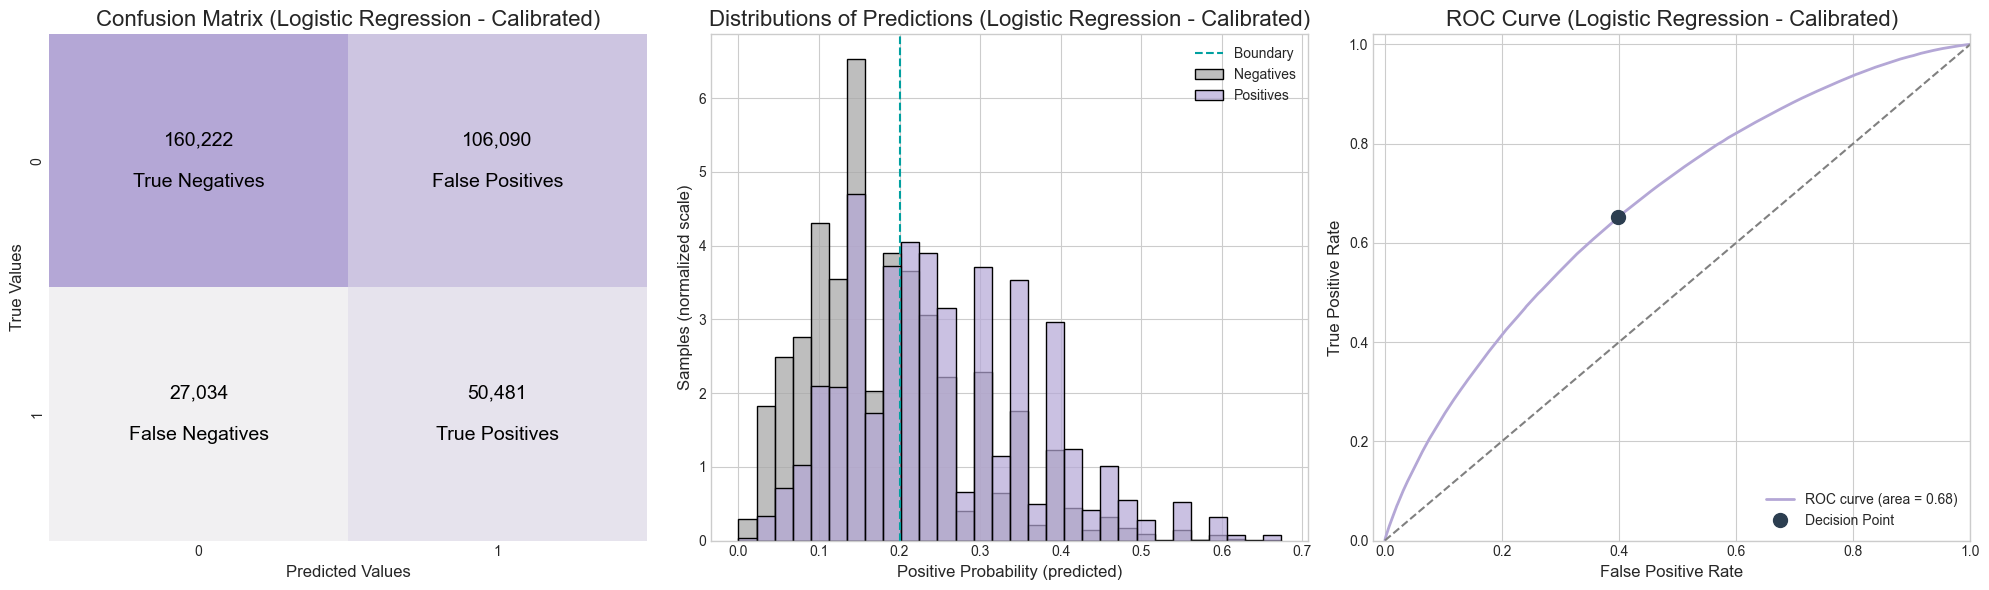

In [15]:
plot_model_evaluation_summary(
    base_model=final_logistic_model,              
    X_data=X_test,
    y_true=y_test.values.ravel(),
    calibrator=lr_isotonic_calibrator, 
    model_name='Logistic Regression',
    custom_color='#b4a7d6',
    threshold=optimal_threshold   
)

# Save models

In [17]:
joblib.dump(final_logistic_model, 'final_logistic_model_undersampling.joblib')

joblib.dump(lr_isotonic_calibrator, 'lr_isotonic_calibrator_undersampling.joblib')

['lr_isotonic_calibrator_undersampling.joblib']